# 5.2 K-Nearest Neighbors for Regression

The disadvantage of linear regression is that it assumes a linear relationship between the features and the label. In this section, we will see another regressor that does not make this assumption, a model known as $k$-nearest neighbors.

We will use the Ames housing data set as the training data. First, let's read in the data set.

## Documentation

* SciKitLearn Preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html
* SciKitLearn preprocessing.StandardScaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
* SciKitLearn K Neares Neighbors Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.max_rows = 5

housing_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt", 
                         sep="\t")
housing_df

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0         1  526301100           20        RL         141.0     31770   Pave   
1         2  526350040           20        RH          80.0     11622   Pave   
...     ...        ...          ...       ...           ...       ...    ...   
2928   2929  924100070           20        RL          77.0     10010   Pave   
2929   2930  924151050           60        RL          74.0      9627   Pave   

     Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0      NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1      NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
...    ...       ...          ...  ...       ...     ...    ...          ...   
2928   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
2929   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   

     Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0           0       5    2010       WD           Normal     215000  
1           0       6    2010       WD           Normal     105000  
...       ...     ...     ...       ...             ...        ...  
2928        0       4    2006       WD           Normal     170000  
2929        0      11    2006       WD           Normal     188000  

[2930 rows x 82 columns]

Let's focus on just two features for now: square footage (of the dwelling) and the number of bedrooms. Let's plot the training data, using a color gradient to represent the labels. Notice how we can customize the color gradient using the `cmap=` argument. A list of the available colormaps can be found [here](https://matplotlib.org/examples/color/colormaps_reference.html).

<AxesSubplot:xlabel='Gr Liv Area', ylabel='Bedroom AbvGr'>

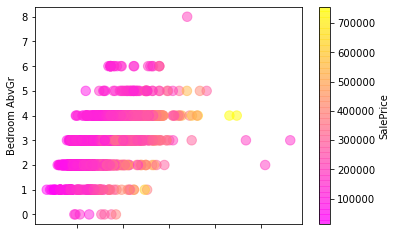

In [2]:
housing_df.plot.scatter(x="Gr Liv Area", y="Bedroom AbvGr", 
                        c="SalePrice", cmap="spring", alpha=.5, s=90)

Notice how points that are close on this plot tend to have similar house prices. This insight is the basis of the $k$-nearest neighbors algorithm for predicting house prices. Suppose that we want to predict the price of a 4000 square foot home with 3 bedrooms, represented by a black circle on the plot below.

![](regression.png)

We can find the $k$ points that are closest to this point in feature space and average their prices as our prediction. For example, the 30-nearest neighbors in the training data to the new home are illustrated in the plot below. We would average the prices of these 30 homes to obtain the predicted price for the new home.

![](regression_neighbors.png)

The $k$-nearest neighbors regression algorithm can be summarized as follows:

1. Determine the $k$ closest points in the training data to the new point that you want to predict for, based on some distance metric on the features.
2. The predicted label of the new point is the mean (or median) of the labels of the $k$ closest points.

# Implementing $K$-Nearest Neighbors from Scratch

Let's first implement the $k$-nearest neighbors from scratch. First, we extract the training data and scale the features:

In [3]:
# define the training features and label
X_train = housing_df[["Gr Liv Area", "Bedroom AbvGr"]]
y_train = housing_df["SalePrice"]

# standardize the training data
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_sc = (X_train - X_train_mean) / X_train_std

Then, we create a `DataFrame` with one row for the new house, using the same scaler to transform the data:

In [4]:
X_train_sc

Gr Liv Area  Bedroom AbvGr
0        0.309212       0.176064
1       -1.194223      -1.032058
...           ...            ...
2928    -0.218968      -1.032058
2929     0.989715       0.176064

[2930 rows x 2 columns]

In [5]:
# define the features for the new observation
x_new = pd.Series([4000,3], index=["Gr Liv Area", "Bedroom AbvGr"])
#x_new["Gr Liv Area"] = 4000
#x_new["Bedroom AbvGr"] = 3

# standardize the new observation using the same mean and SD as before
x_new_sc = (x_new - X_train_mean) / X_train_std
x_new, x_new_sc

(Gr Liv Area      4000
 Bedroom AbvGr       3
 dtype: int64,
 Gr Liv Area      4.946124
 Bedroom AbvGr    0.176064
 dtype: float64)

Now we calculate the (Euclidean) distances between this new house and each house in the training data.

In [6]:
dists = np.sqrt(((x_new_sc - X_train_sc) ** 2).sum(axis=1))
dists

0       4.636912
1       6.258068
          ...   
2928    5.304501
2929    3.956409
Length: 2930, dtype: float64

We get the indices that would sort these distances and take the first 30, which represent the 30 nearest neighbors.

In [7]:
i_nearest = dists.sort_values().index[:30]
i_nearest

Int64Index([1306, 2181, 1767, 2445, 2666, 1760, 2450, 1537, 2045,   15,   65,
            1772,  565, 2214,  422, 2336, 1182, 2570, 1945, 1764, 2500, 2453,
            2329, 1320, 1497, 2180, 1572, 2737, 2218, 1022],
           dtype='int64')

Now we can look up these indices in the original data.

In [8]:
housing_df.loc[i_nearest]

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1306   1307  902207220           75        RM          87.0     18386   Pave   
2181   2182  908154205           60        RL         130.0     40094   Pave   
...     ...        ...          ...       ...           ...       ...    ...   
2218   2219  909281130           70        RL          70.0     10570   Pave   
1022   1023  527325070           60        RL           NaN     12227   Pave   

     Alley Lot Shape Land Contour  ... Pool Area Pool QC Fence Misc Feature  \
1306   NaN       Reg          Lvl  ...         0     NaN   NaN          NaN   
2181   NaN       IR1          Bnk  ...         0     NaN   NaN          NaN   
...    ...       ...          ...  ...       ...     ...   ...          ...   
2218   NaN       Reg          Bnk  ...         0     NaN   NaN          NaN   
1022   NaN       IR1          Lvl  ...         0     NaN   NaN          NaN   

     Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
1306        0       5    2008       WD           Normal     295000  
2181        0      10    2007       New         Partial     184750  
...       ...     ...     ...       ...             ...        ...  
2218        0      12    2007       WD           Normal     315000  
1022        0       7    2008       WD           Normal     272000  

[30 rows x 82 columns]

To make a prediction for the price of this new house, we average the sale prices of these 30 nearest neighbors.

In [9]:
y_train.loc[i_nearest].mean()

382429.23333333334

So the model predicts that the house is worth $382,429.

# $K$-Nearest Neighbors in _scikit-learn_

Now let's see how to use the _scikit-learn_ library to fit the same model. First, we standardize the training data and the new data. Note that _scikit-learn_ requires that the features be stored in a two-dimensional array, so we need to convert `x_new`, which is a `Series`, into a `DataFrame` with one row. We will distinguish the `DataFrame` by using a capital letter `X` (to suggest that that this is a matrix).

In [10]:
X_new = pd.DataFrame([x_new])
X_new

Gr Liv Area  Bedroom AbvGr
0         4000              3

In [11]:
X_train

Gr Liv Area  Bedroom AbvGr
0            1656              3
1             896              2
...           ...            ...
2928         1389              2
2929         2000              3

[2930 rows x 2 columns]

In [12]:
from sklearn.preprocessing import StandardScaler

# standardize the training data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

# use the same scaler to standardize the new data
X_new_sc = scaler.transform(X_new)

X_new_sc

array([[4.9469681 , 0.17609421]])

Now we use the standard _scikit-learn_ three-step interface for fitting a machine learning model and using it to make predictions. The code below is virtually identical to the code from the previous section on linear regressor, with two distinctions:

- We use `KNeighborsRegressor` as the model instead of `LinearRegression`.
- We pass in the scaled features to `model.fit()` and `model.predict()` instead of the raw features. You could have done this with `LinearRegression` as well, but scaling does not change the predictions from a linear regression model; see Exercise 2 from Chapter 5.1.

In [13]:
from sklearn.neighbors import KNeighborsRegressor

# Step 1: Declare the model.
model = KNeighborsRegressor(n_neighbors=30)

# Step 2: Fit the model to the (scaled) training data.
# This step stores the training data in a data structure 
# that is efficient for calculating distances.
model.fit(X_train_sc, y_train)

# Step 3: Use the model to predict for new observations.
model.predict(X_new_sc)

array([382429.23333333])

Let's see how our prediction is affected by the value of `n_neighbors`

In [17]:
neighbor_values = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100])

models = [KNeighborsRegressor(n_neighbors=x) for x in neighbor_values]

models = [m.fit(X_train_sc,y_train) for m in models]

predictions = np.array([m.predict(X_new_sc) for m in models])
#predictions

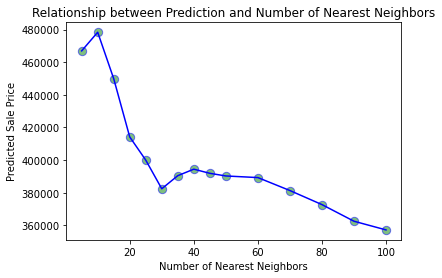

In [20]:
plt.figure()
plt.title("Relationship between Prediction and Number of Nearest Neighbors")
plt.xlabel("Number of Nearest Neighbors")
plt.ylabel("Predicted Sale Price")
plt.scatter(x=neighbor_values, y=predictions, c="green", s=70, alpha=0.5, edgecolors="blue")
plt.plot(neighbor_values, predictions, c="blue")
plt.show()

# The $K$-Nearest Neighbors Regression Function

In the previous section, we fit a linear regression model with a single feature so that we could visualize what $f(x)$ looked like. With linear regression, $f(x)$ is a line. What does $f(x)$ look like for a $k$-nearest neighbors model? Let's train a $k$-nearest neighbors model that predicts the price of a home from just the square footage.

First, we extract the training data. Notice that X_train is a `DataFrame` with one column, rather than a `Series`, because _pandas_ requires the features to be in the form of a two-dimensional array.

In [21]:
X_train = housing_df[["Gr Liv Area"]]
y_train = housing_df["SalePrice"]

X_train

Gr Liv Area
0            1656
1             896
...           ...
2928         1389
2929         2000

[2930 rows x 1 columns]

Now let's fit the $k$-nearest neighbors regressor in _scikit-learn_. There is no need to scale the features in this case because there is only one feature. (The purpose of scaling is to bring different features to the same scale, but this is not necessary when there is only one feature.)

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

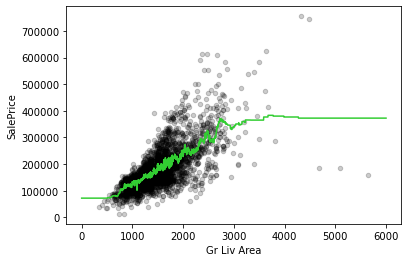

In [22]:
housing_df.plot.scatter(
    x="Gr Liv Area", y="SalePrice",
    c="black", alpha=.2
)

# Step 1: Declare the model.
model = KNeighborsRegressor(n_neighbors=30)

# Step 2: Fit the model to the training data.
model.fit(X_train, y_train)

# Step 3: Use the model to predict for a grid of new observations.
x_new = pd.Series(
    data=np.arange(0, 6000, step=1),
    index=np.arange(0, 6000, step=1)
)
X_new = x_new.to_frame()
y_new_ = model.predict(X_new)

# scikit-learn always returns numpy arrays. We will
# turn it into a Series for easy plotting.
pd.Series(index=x_new, data=y_new_).plot.line(color="limegreen")

Contrast this with the prediction model for linear regression that we graphed in the previous section. This prediction model is decidedly non-linear.

# Exercises

**Exercise 1.** Plot the $k$-nearest neighbors regression function for predicting sale price from just its square footage for $k=5, 30, 100$. How does the regression function change as $k$ increases?

In [ ]:
# TYPE YOUR CODE HERE

**Exercise 2.** Fit a $k$-nearest neighbors regressor that predicts sale price using the features below. The choice of $k$ is up to you. Use your model to predict the price of the house whose features are given in `new_df` below.

_Hint:_ Note that there are a mixture of quantitative and categorical variables in this feature set. You will have to encode the categorical features as quantitative variables before you can scale the variables and fit the model. Refer to the previous section for the code to do this.

In [ ]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood", "Bldg Type"]

new_df = pd.DataFrame(
    columns=features,
    data=[
        {"Lot Area": 9000,
         "Gr Liv Area": 1400,
         "Full Bath": 2,
         "Half Bath": 1,
         "Bedroom AbvGr": 3,
         "Year Built": 1980,
         "Yr Sold": 2011,
         "Neighborhood": "OldTown",
         "Bldg Type": "1Fam"}
    ]
)

# TYPE YOUR CODE HERE

**Exercise 3.** You would like to predict how much a male diner will tip on a bill of \\$40.00 on a Sunday. Build a $k$-nearest neighbors model to answer this question, using the Tips dataset (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv`) as your training data.

In [ ]:
# TYPE YOUR CODE HERE

**Challenge Exercise.** We visualized the $k$-nearest neighbors regression function above, in the special case where there is only one feature. It is also possible to visualize a regression function in the case where there are two features, using a heat map, where the two axes represent the two features and the color represents the label.

Make a heat map that shows the 30-nearest neighbors regression function when there are two features in the model: square footage (`Gr Liv Area`) and number of bedrooms (`Bedroom AbvGr`).

In [ ]:
# TYPE YOUR CODE HERE